## Utils

In [1]:
# @title Parsing JSON output
def parse_json(json_output: str):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i + 1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [2]:
# @title Plotting Util

import json
import io
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]


def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        im: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
                 'red',
                 'green',
                 'blue',
                 'yellow',
                 'orange',
                 'pink',
                 'purple',
                 'brown',
                 'gray',
                 'beige',
                 'turquoise',
                 'cyan',
                 'magenta',
                 'lime',
                 'navy',
                 'maroon',
                 'teal',
                 'olive',
                 'coral',
                 'lavender',
                 'violet',
                 'gold',
                 'silver',
             ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("assets/2d_spatial_understanding/NotoSansSC-Regular.ttf", size=14)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json.loads(bounding_boxes)):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_y1 = int(bounding_box["box_2d"][0] / 1000 * height)
        abs_x1 = int(bounding_box["box_2d"][1] / 1000 * width)
        abs_y2 = int(bounding_box["box_2d"][2] / 1000 * height)
        abs_x2 = int(bounding_box["box_2d"][3] / 1000 * width)

        if abs_x1 > abs_x2:
            abs_x1, abs_x2 = abs_x2, abs_x1

        if abs_y1 > abs_y2:
            abs_y1, abs_y2 = abs_y2, abs_y1

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        if "label" in bounding_box:
            draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()

## Launch

In [3]:
import os

import dotenv
from google import genai
from google.genai import types

dotenv.load_dotenv()

GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

In [4]:
bounding_box_system_instructions = """
Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
"""

In [6]:
from PIL import Image
from io import BytesIO
from google.genai.types import ThinkingConfig
from pathlib import Path

output_dir = Path("assets/2d_spatial_understanding")

image = output_dir.joinpath("gis_guess.jpg")

prompt = """
Detect the 2d bounding boxes of the following objects (with “label” as topping description”):
- small piles of debris
- dirt roads
- upright telephone poles
- trees
- undamaged houses
"""

# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024, 1024], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model="gemini-2.5-pro-exp-03-25",
    contents=[prompt, im],
    config=types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        thinking_config=ThinkingConfig(
            thinking_budget=4000
        )
    )
)



(1024, 512)


In [7]:
from IPython.display import Markdown

Markdown(response.text)

```json
[
  {"box_2d": [541, 27, 859, 595], "label": "dirt roads"},
  {"box_2d": [519, 560, 859, 998], "label": "dirt roads"},
  {"box_2d": [314, 233, 559, 377], "label": "undamaged houses"},
  {"box_2d": [430, 572, 541, 675], "label": "undamaged houses"},
  {"box_2d": [345, 763, 548, 902], "label": "undamaged houses"},
  {"box_2d": [445, 370, 519, 423], "label": "undamaged houses"},
  {"box_2d": [480, 957, 530, 998], "label": "undamaged houses"},
  {"box_2d": [316, 106, 624, 250], "label": "trees"},
  {"box_2d": [395, 413, 550, 462], "label": "trees"},
  {"box_2d": [375, 520, 552, 577], "label": "trees"},
  {"box_2d": [436, 456, 537, 493], "label": "trees"},
  {"box_2d": [375, 577, 537, 640], "label": "trees"},
  {"box_2d": [334, 680, 537, 750], "label": "trees"},
  {"box_2d": [406, 737, 530, 777], "label": "trees"},
  {"box_2d": [406, 62, 532, 120], "label": "trees"},
  {"box_2d": [43, 0, 744, 410], "label": "trees"},
  {"box_2d": [4, 510, 552, 1000], "label": "trees"},
  {"box_2d": [478, 509, 510, 532], "label": "trees"},
  {"box_2d": [441, 485, 530, 498], "label": "upright telephone poles"},
  {"box_2d": [419, 13, 534, 56], "label": "trees"},
  {"box_2d": [436, 80, 550, 123], "label": "upright telephone poles"},
  {"box_2d": [412, 932, 541, 992], "label": "trees"},
  {"box_2d": [561, 156, 742, 405], "label": "small piles of debris"}
]
```

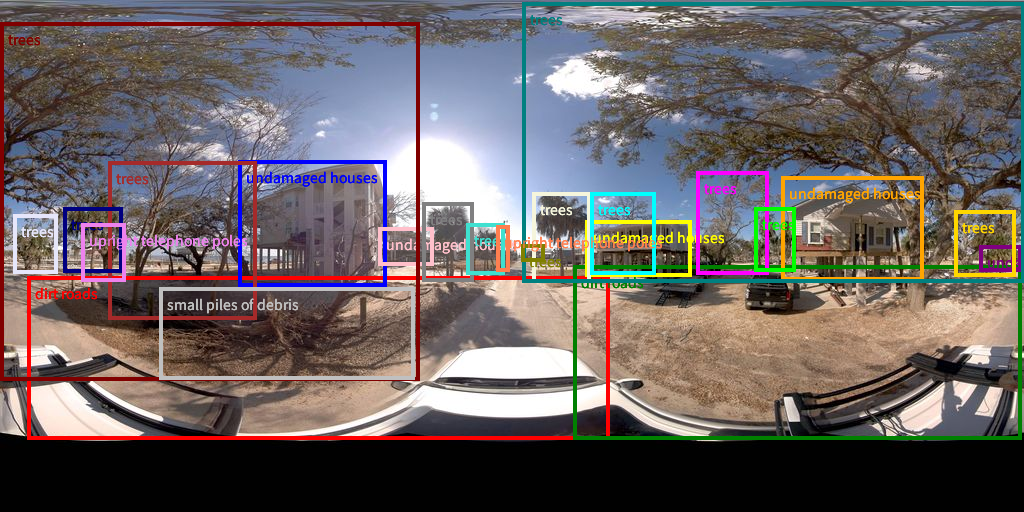

In [10]:
plot_bounding_boxes(im, response.text)
im